In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# $y⁺$ and first cell calculations

(The equations can be found at https://www.computationalfluiddynamics.com.au/tips-tricks-cfd-estimate-first-cell-height/)

* Reynolds number:

$$
Re = \frac{\rho U L}{\mu}
$$

* $y^+$ value:

$$
y^+=\frac{\rho U_\tau (\Delta y_1)}{\mu}
$$

* Frictional velocity:

$$
U_\tau = \sqrt{\frac{\tau_w}{\rho}}
$$

* Wall shear stress:

$$
\tau_w = \frac{1}{2} C_f \rho U^2 \text{where} \begin{Bmatrix} \text{Internal flows:} && C_f = 0.079 Re^{-0.25} \\ \text{External flows:} && C_f = 0.058 Re^{-0.2} \end{Bmatrix}
$$

Adding up everything, the resulting equation for the height of the first cell is:

$$
\Delta y_1 = \frac{y^+ \mu}{\rho \sqrt{0.5 \cdot C_f U^2}}
$$

In [2]:
# objective for y plus value
target_yplus = 10
# velocity of the inocming flow
U = 10 # m/s
# characteristic length
L = 1 # m
# kinematic density
mu = 0.00001789 # Pa*s
# density of the flow
rho = 1.2 # kg*m-3
# kind of flow
flow = 'e' # 'i'(nternal) or 'e'(xternal)

In [3]:
# computation of the Reynolds number
Re = (rho*U*L)/(mu)

# external flow friction coefficient
if flow == 'e':
    cf = 0.058*Re**(-0.2)
# internal flow friction coefficient
else:
    cf = 0.079*Re**(-0.25)
    
# height of the first cell
dy1 = target_yplus*mu/(rho*np.sqrt(0.5*cf*U**2))

# Expansion ratio calculator

The expansion ratio is usually defined with a geometric series:
$$
y_1 = a y_0, \ ... \ y_i = a y_{i-1}
$$

If the expansion ratio ($\varepsilon$) and the number of layers are known, the different points of the layers can be computed.

In [4]:
# expansion ratio known as a if y1 = a*y0
expansionRatio = 1.321
# number of layer in the BL inflation
NoLayers = 15

In [5]:
# preallocation of space for the location of each layer
layerSize = dy1*np.ones(NoLayers)

# computation of the height of each layer
for i in range (1, NoLayers):
    layerSize[i] = layerSize[i-1]*expansionRatio

# cumulative sum of the size of the layers, giving the total y coordinate
yCoord = np.cumsum(layerSize)

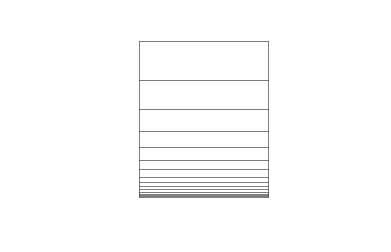

In [6]:
# attempt to plot a boundary layer
plt.plot([0,0],[0,yCoord[NoLayers-1]],'k',lw=0.5)
plt.plot([0.1*yCoord[NoLayers-1],0.1*yCoord[NoLayers-1]],[0,yCoord[NoLayers-1]],'k',lw=0.5)
plt.plot([0,0.1*yCoord[NoLayers-1]],[0,0],'k',lw=0.5)
for i in range(NoLayers):
    plt.plot([0,0.1*yCoord[NoLayers-1]],[yCoord[i],yCoord[i]],'k',lw=0.5)
plt.xlim([-0.08*yCoord[NoLayers-1],0.18*yCoord[NoLayers-1]])
plt.ylim([-0.2*yCoord[NoLayers-1],1.2*yCoord[NoLayers-1]])
plt.axis('off');

# Boundary layer approximation for blockMesh generated domains

If the whole domain number of cells and the boundary layer divisions are known, the expansion ratio and percentage distribution can be computed. Using the equations (and some code) from [airfoil-parametrization/NACA4/NACA_4digit.ipynb](https://github.com/jlobatop/GA-CFD-MO/blob/master/airfoil-parametrization/NACA4/NACA_4digit.ipynb):

$$
\varepsilon = a^{N-1}
$$

In [7]:
# length of the domain
length = 1
# number of cells (bigger than BL_cells)
totalCells = 30
# direction: 't' (towards the surface) or 'a' (away from the surface)
grid_dir = 't'

In [8]:
# length of the boundary layer
BL_length = yCoord[-1]
# expansion ration of the boundary layer for blockMesh
bm_expRatio = expansionRatio**(NoLayers-1)

In [9]:
# if the grid is oriented towards the surface
if grid_dir == 't':
    # percentage of the length is divided as
    perc = np.array([BL_length/length, 1-BL_length/length])
    #  number of cells is divided as
    cells = np.array([NoLayers/totalCells, (totalCells-NoLayers)/totalCells])
    # expansion ratio
    exp = np.array([bm_expRatio, 1])
# if it is oriented away from it
else:
    # percentage of the length is divided as    
    perc = np.array([1-BL_length/length, BL_length/length])
    #  number of cells is divided as
    cells = np.array([(totalCells-NoLayers)/totalCells, NoLayers/totalCells])
    # expansion ratio
    exp = np.array([1, bm_expRatio])

In [10]:
def simple_grading(N, expRatio, L):
    # size of each cell array
    delta = np.zeros(N) 
    # position of the nodes
    nodes = np.zeros(N+1) 

    # value of k for all the line
    kVal = expRatio**((1)/(N-1)) 
    # increment of k for each cell
    k = np.zeros(N)

    # compute that incremental k
    for i in range(N):
        k[i] = kVal**(i) 

    # first cell size 
    deltaS = L/np.sum(k)
    # size of each cell
    delta = deltaS*k 
    
    # compute the location of the nodes
    for i in range(N):
        nodes[i+1] = nodes[i] + delta[i]

    return nodes

In [11]:
def grading_plot(x): #nodes is the input from simple_grading

    # get a y-coordinate vector for the x-shape
    y = 0.5*np.ones(np.shape(x)[0])
    
    # create the figure
    fig, ax = plt.subplots(figsize=(20, 1), dpi=100)
        
    # plot the line and the nodes
    ax.set_xlim(-x[1]*0.5,1.1*x[-1])
    ax.set_ylim(0,1)
    ax.axis('off')
    ax.plot([x[0],x[-1]],[y[0],y[-1]],'k')
    ax.scatter(x,y,c='k')

In [12]:
def multi_grading(perc, cells, eps, N, L): 
    
    # some initial shape and value comprobations
    if np.sum(perc) != 1:
        raise ValueError('Bad percentage array input')
        return

    if np.sum(cells) != 1:
        raise ValueError('Bad cell array input')
        return
    
    if np.shape(perc)[0] != np.shape(cells)[0] or np.shape(perc)[0] != np.shape(eps)[0] or np.shape(cells)[0] != np.shape(eps)[0]:
        raise ValueError('Non equal vector definition')
        return

    # cells per segment
    segmentN = (N*cells) 

    # in case there are decimal values
    restCells = np.modf(segmentN)[0] 

    # integer value of the cells
    segmentN = np.trunc(segmentN) 
    
    # distribution of the 'decimal' parts of the cells
    i = np.sum(restCells) 

    # compute the correct subdivisions of the cells
    while i > 0:
        segmentN[np.argmax(restCells)] = segmentN[np.argmax(restCells)] + int(i)
        restCells[np.argmax(restCells)] = 0
        i -= 1
   
    # length per segment
    segmentL = (L*perc) 

    # number of nodes    
    nodes = np.zeros(N+1)
    
    # compute the location of each node in the line
    for i in range(np.shape(perc)[0]):
        nodesTemp = simple_grading(int(segmentN[i]), eps[i], segmentL[i])
        for j in range(np.shape(nodesTemp)[0]):
            if i == 0:
                nodes[j] = nodesTemp[j]
            else:
                nodes[int(np.cumsum(segmentN)[i-1]) + j] = nodesTemp[j] + nodes[int(np.cumsum(segmentN)[i-1])]

    return nodes

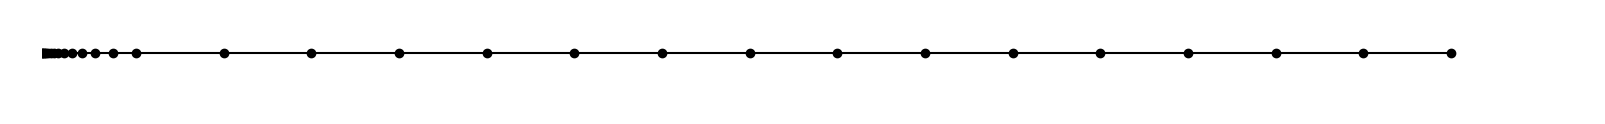

In [13]:
grading_plot(multi_grading(perc, cells, exp, 30, 1))

# Complete function integration

In [14]:
def BLcalculator(target_yplus, U, L, mu, rho, flow, expansionRatio, NoLayers, length, totalCells, grid_dir):
    # calculator of the boundary layer parameters from the different values
    
    # computation of the Reynolds number
    Re = (rho*U*L)/(mu)

    # external flow friction coefficient
    if flow == 'e':
        cf = 0.058*Re**(-0.2)
    # internal flow friction coefficient
    else:
        cf = 0.079*Re**(-0.25)

    # height of the first cell
    dy1 = target_yplus*mu/(rho*np.sqrt(0.5*cf*U**2))
    
    # preallocation of space for the location of each layer
    layerSize = dy1*np.ones(NoLayers)

    # computation of the height of each layer
    for i in range (1, NoLayers):
        layerSize[i] = layerSize[i-1]*expansionRatio

    # cumulative sum of the size of the layers, giving the total y coordinate
    yCoord = np.cumsum(layerSize)
    
    # length of the boundary layer
    BL_length = yCoord[-1]
    # expansion ration of the boundary layer for blockMesh
    bm_expRatio = expansionRatio**(NoLayers-1)
    
    # if the grid is oriented towards the surface
    if grid_dir == 't':
        # percentage of the length is divided as
        perc = np.array([BL_length/length, 1-BL_length/length])
        #  number of cells is divided as
        cells = np.array([NoLayers/totalCells, (totalCells-NoLayers)/totalCells])
        # expansion ratio
        exp = np.array([bm_expRatio, 1])
    # if it is oriented away from it
    else:
        # percentage of the length is divided as    
        perc = np.array([1-BL_length/length, BL_length/length])
        #  number of cells is divided as
        cells = np.array([(totalCells-NoLayers)/totalCells, NoLayers/totalCells])
        # expansion ratio
        exp = np.array([1, bm_expRatio])
    
    return perc, cells, exp